---
### Machine Learning Regression Model
---
#### I. Load the data

In [86]:
import pandas as pd

df = pd.read_excel('data/Microsoft_LinkedIn_Processed.xlsx', parse_dates=['Date'], index_col=0)
df.head(n=5)

,Close,High,Low,Open,Volume,change_tomorrow,change_tomorrow_direction
Date,,,,,,,
2016-12-08,55.181126,55.696671,55.027369,55.443420,21220800,1.549151,UP
2016-12-09,56.049416,56.067505,55.289669,55.334891,27349400,0.321666,UP
2016-12-12,56.230289,56.347870,55.823285,55.913730,20198100,1.286169,UP
2016-12-13,56.962929,57.360890,56.293630,56.528788,35718900,-0.478644,DOWN
2016-12-14,56.691578,57.388013,56.555907,56.981005,30352700,-0.159789,DOWN


---
#### II. Machine Learning Model

Separate the data:

1. Target: which variable do you want to predict?
2. Explanatory: which variables will you use to calculate the prediction?

In [87]:
target = df.change_tomorrow
explanatory = df[['Open','High','Low','Close','Volume']]

Compute the model: The following model will predict the **numerical increase** of the stock for the following day.

As the variable we predict is numerical, we talk about regression models. In the previous tutorial, we used a classification model since the variable we predicted was categorical (UP or DOWN).

In [88]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(max_depth=15)
model_dt.fit(X=explanatory, y=target)

DecisionTreeRegressor(max_depth=15)

---
#### III. Compute the predictions

In [89]:
y_pred = model_dt.predict(X=explanatory)
df_predictions = df[['change_tomorrow']].copy()

df_predictions['prediction'] = y_pred

df_predictions.head(n=5)

,change_tomorrow,prediction
Date,,
2016-12-08,1.549151,0.143233
2016-12-09,0.321666,0.143233
2016-12-12,1.286169,0.143233
2016-12-13,-0.478644,0.224172
2016-12-14,-0.159789,0.143233


---
#### IV. Evaluate the model: compare predictions with the reality

In [90]:
accuracy = model_dt.score(X=explanatory, y=target)
print(f"Decision Tree Accuracy: {accuracy:.2%}.")

Decision Tree Accuracy: 40.92%.


In [91]:
import matplotlib.pyplot as plt
import numpy as np

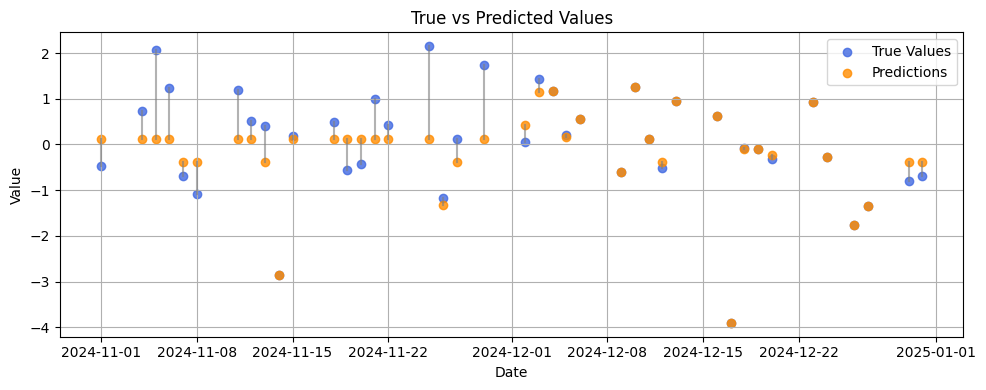

In [92]:
# Filter for date range November-December 2024
df_filtered = df_predictions.loc["2024-11-01":"2024-12-31"]

plt.figure(figsize=(10, 4))
plt.scatter(df_filtered.index, df_filtered["change_tomorrow"], label="True Values", color="royalblue", alpha=0.8)
plt.scatter(df_filtered.index, df_filtered["prediction"], label="Predictions", color="darkorange", alpha=0.8)

# Error lines
for i in df_filtered.index:
    plt.plot([i, i],
             [df_filtered.loc[i, "change_tomorrow"], df_filtered.loc[i, "prediction"]],
             color='gray', linestyle='-', alpha=0.6)

plt.title("True vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We need to compute:

$$
\begin{array}{c|c}
\textbf{Metric} & \textbf{Formula} \\
\hline
\text{RSS} & \sum (y_i - \hat{y}_i)^2 \\
\text{TSS} & \sum (y_i - \bar{y})^2 \\
\text{MSE} & \dfrac{1}{n} \sum (y_i - \hat{y}_i)^2 \\
\text{RMSE} & \sqrt{\text{MSE}}
\end{array}
$$

In [93]:
# Residuals
df_predictions['resid'] = df_predictions['prediction'] - df_predictions['change_tomorrow']
print(f"The residuals sum up to: {df_predictions.resid.sum().round(2)}.")

# RSS: Residual Sum of Squares
df_predictions['resid2'] = df_predictions['resid'] ** 2
rss = df_predictions['resid2'].sum().round(2)
print(f"The RSS (sum of squares of residuals) is: {rss}.")

# TSS: Total Sum of Squares
tss = ((df_predictions['change_tomorrow'] - df_predictions['change_tomorrow'].mean()) ** 2).sum().round(2)
print(f"The TSS (total sum of squares) is: {tss}.")

The residuals sum up to: 0.0.
The RSS (sum of squares of residuals) is: 3697.87.
The TSS (total sum of squares) is: 6259.5.


We can now compute the $R^2$:
$$
R^2 = 1 - \frac{RSS}{TSS}
$$

In [94]:
r2 = 1 - (rss / tss)
print(f"R² Score: {r2:.4f}.")

R² Score: 0.4092.


In [100]:
# MSE: Mean Squared Error
mse = df_predictions['resid2'].mean()
print(f"The Mean Squared Error (MSE): {mse:.4f}.")

# RMSE: Root Mean Squared Error
rmse = np.sqrt(mse)
print(f"The Root Mean Squared Error (RMSE): {rmse:.2f}.")

The Mean Squared Error (MSE): 1.7685.
The Root Mean Squared Error (RMSE): 1.33.


The formula for the **population standard deviation** is:

$$
\sigma = \sqrt{ \frac{1}{n} \sum (x_i - \mu)^2 }
$$

Where:  
- $\sigma$ = population standard deviation  
- $n$ = the size of the population  
- $x_i$ = each value from the population  
- $\mu$ = the population mean

**Note**: When the mean $\mu$ is **zero**, the standard deviation formula becomes:

$$
\sigma = \sqrt{ \frac{1}{n} \sum x_i^2 }
$$

This is exactly the same as the **RMSE** formula:

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum (y_i - \hat{y}_i)^2 }
$$

So when modeling errors are centered around 0, **RMSE is equivalent to the standard deviation of the residuals**.


In [96]:
# Compare RMSE and std
resid_std = df_predictions['resid'].std()
print(f"The residuals have a std of: {resid_std:.2f}.")

The residuals have a std of: 1.33.


Recall the **68-95-99.7 rule** (*cf. Notebook 3.1*):
<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Standard_deviation_diagram.svg/1200px-Standard_deviation_diagram.svg.png" width="600"/>
</p>

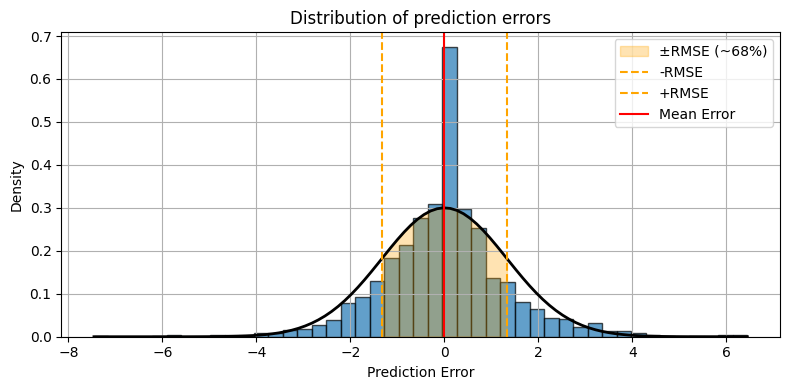

In [97]:
from scipy.stats import norm

errors = df_predictions['resid']
mean_error = errors.mean()

plt.figure(figsize=(8, 4))
count, bins, _ = plt.hist(errors, bins=45, edgecolor='black', alpha=0.7, density=True)

# Normal curve
x = np.linspace(min(bins), max(bins), 100)
p = norm.pdf(x, loc=mean_error, scale=rmse)
plt.plot(x, p, 'k', linewidth=2)

# Fill ±1 RMSE area
x_fill = np.linspace(mean_error - rmse, mean_error + rmse, 100)
plt.fill_between(x_fill, norm.pdf(x_fill, mean_error, rmse), alpha=0.3, color='orange', label=r'±RMSE (~68%)')

# ±1 RMSE markers
plt.axvline(mean_error - rmse, color='orange', linestyle='--', label='-RMSE')
plt.axvline(mean_error + rmse, color='orange', linestyle='--', label='+RMSE')
plt.axvline(mean_error, color='red', linestyle='-', label='Mean Error')

plt.title(r"Distribution of prediction errors")
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation of Error Distribution**

The histogram above shows the distribution of prediction errors from our regression model. 

We approximate this distribution using a normal curve centered at the **mean error**, and we use the **Root Mean Squared Error (RMSE)** as the standard deviation.

This makes sense because:

- The RMSE represents the **standard deviation of the errors**,
- Under the assumption that the errors follow a normal distribution $\mathcal{N}(0, \text{RMSE})$,
- Then **about 68% of the prediction errors fall between $-\text{RMSE}$ and $+\text{RMSE}$**.

This means the model’s predictions are, in most cases, within one RMSE of the true value.

> A good model minimizes the RMSE!

---
#### V. Save the model

We'll write the numbers of the Decision Tree's mathematical equation into a file.

In [98]:
import pickle

In [99]:
with open('models/model_dt_regression.pkl', 'wb') as f:
    pickle.dump(model_dt, f)